# Model Tuning
## Goals
1. Establish baseline performance from previous models.
2. Systematically tune hyperparameters of RandomForestRegressor using GridSearchCV.
3. Compare tuned vs. baseline models.
4. Save the best-performing tuned model.

In [4]:
import json
import pickle
from pathlib import Path

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
from numpy.typing import NDArray
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    StratifiedKFold,
    learning_curve,
)
from xgboost import XGBClassifier

In [5]:
# Constants
PROCESSED_DATA_DIR = Path("../../data/cleaned/classification/")
FIGURES_DIR = Path("../../figures/classification/")
MODELS_DIR = Path("../../models/classification/")
RANDOM_STATE = 42

np.random.seed(RANDOM_STATE)  # Set numpy seed for reproducibility

In [6]:
# Load data
print("Loading feature-engineered data...")
X_train = pl.read_parquet(PROCESSED_DATA_DIR / "X_train_scaled.parquet")
X_val = pl.read_parquet(PROCESSED_DATA_DIR / "X_val_scaled.parquet")
X_test = pl.read_parquet(PROCESSED_DATA_DIR / "X_test_scaled.parquet")

y_train = pl.read_parquet(PROCESSED_DATA_DIR / "y_train.parquet")
y_val = pl.read_parquet(PROCESSED_DATA_DIR / "y_val.parquet")
y_test = pl.read_parquet(PROCESSED_DATA_DIR / "y_test.parquet")

# Convert to numpy for sklearn
X_train_np = X_train.to_numpy()
X_val_np = X_val.to_numpy()
X_test_np = X_test.to_numpy()

y_train_np = y_train.to_numpy().ravel()
y_val_np = y_val.to_numpy().ravel()
y_test_np = y_test.to_numpy().ravel()

print(f"X_train: {X_train_np.shape}, y_train: {y_train_np.shape}")
print(f"X_val: {X_val_np.shape}, y_val: {y_val_np.shape}")
print(f"X_test: {X_test_np.shape}, y_test: {y_test_np.shape}")

Loading feature-engineered data...
X_train: (9440, 127), y_train: (9440,)
X_val: (1977, 127), y_val: (1977,)
X_test: (2025, 127), y_test: (2025,)


In [7]:
# Same Evaluation Function as before
def evaluate_model(
    model_name: str,
    y_train_pred: NDArray[np.bool],
    y_val_pred: NDArray[np.bool],
    y_train_pred_proba: NDArray[...] = None,
    y_val_pred_proba: NDArray[...] = None,
):
    results = {}
    train_metrics = {
        "Accuracy": accuracy_score(y_train_np, y_train_pred),
        "Precision": precision_score(y_train_np, y_train_pred, zero_division=0),
        "Recall": recall_score(y_train_np, y_train_pred, zero_division=0),
        "F1": f1_score(y_train_np, y_train_pred, zero_division=0),
        "Balanced Accuracy": balanced_accuracy_score(y_train_np, y_train_pred),
    }

    if y_train_pred_proba is not None:
        train_metrics["ROC-AUC"] = roc_auc_score(y_train_np, y_train_pred_proba)

    print(f"\033[1m{model_name}: Training Set\033[0m")
    for metric, value in train_metrics.items():
        print(f"  \033[1m{metric:20}:\033[0m {value:.4f}")
    print("")

    results["train"] = train_metrics

    val_metrics = {
        "Accuracy": accuracy_score(y_val_np, y_val_pred),
        "Precision": precision_score(y_val_np, y_val_pred, zero_division=0),
        "Recall": recall_score(y_val_np, y_val_pred, zero_division=0),
        "F1": f1_score(y_val_np, y_val_pred, zero_division=0),
        "Balanced Accuracy": balanced_accuracy_score(y_val_np, y_val_pred),
    }

    if y_val_pred_proba is not None:
        val_metrics["ROC-AUC"] = roc_auc_score(y_val_np, y_val_pred_proba)

    print(f"\033[1m{model_name}: Validation Set\033[0m")
    for metric, value in val_metrics.items():
        print(f"  \033[1m{metric:20}:\033[0m {value:.4f}")

    # Confusion matrix
    cm = confusion_matrix(y_val_np, y_val_pred)
    print(f"\n\033[1mConfusion Matrix: Validation Set\033[0m")
    print(f"  \033[1mTN:\033[0m {cm[0, 0]:<6} \033[1mFP:\033[0m {cm[0, 1]:<6}")
    print(f"  \033[1mFN:\033[0m {cm[1, 0]:<6} \033[1mTP:\033[0m {cm[1, 1]:<6}")

    results["val"] = val_metrics
    results["confusion_matrix"] = cm

    return results


def report_cv_results(cv_results: dict[...], model_name: str):
    """Extract and report cross-validation metrics."""
    print(f"\033[1m{model_name}: 5-Fold Cross-Validation\033[0m")

    metrics_to_report = ["accuracy", "precision", "recall", "f1", "roc_auc"]

    for metric in metrics_to_report:
        train_key = f"train_{metric}"
        test_key = f"test_{metric}"

        if test_key in cv_results:
            mean = cv_results[test_key].mean()
            std = cv_results[test_key].std()
            print(f"  \033[1m{metric.capitalize():20}:\033[0m {mean:.4f} (±{std:.4f})")

    return {
        metric: {
            "mean": cv_results[f"test_{metric}"].mean(),
            "std": cv_results[f"test_{metric}"].std(),
        }
        for metric in metrics_to_report
        if f"test_{metric}" in cv_results
    }

## Baseline Performance
Let's check the baseline performance from our basic Random Regressor.

In [8]:
rf_basic = joblib.load(MODELS_DIR / "random_forest.pkl")

print("Baseline models loaded\n")

# Evaluate the baseline model on the validation set
y_val_pred_rf_basic = rf_basic.predict(X_val_np)
y_val_proba_rf_basic = rf_basic.predict_proba(X_val_np)[:, 1]
y_train_pred_rf_basic = rf_basic.predict(X_train_np)
y_train_proba_rf_basic = rf_basic.predict_proba(X_train_np)[:, 1]

rf_basic_metrics = evaluate_model(
    "Random Forest Classifier",
    y_train_pred_rf_basic,
    y_val_pred_rf_basic,
    y_train_proba_rf_basic,
    y_val_proba_rf_basic,
)

xgb_basic = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=RANDOM_STATE,
    n_jobs=-1,
)

xgb_basic.fit(X_train_np, y_train_np)

y_val_pred_xgb_basic = xgb_basic.predict(X_val_np)
y_val_proba_xgb_basic = xgb_basic.predict_proba(X_val_np)[:, 1]
y_train_pred_xgb_basic = xgb_basic.predict(X_train_np)
y_train_proba_xgb_basic = xgb_basic.predict_proba(X_train_np)[:, 1]

print("\n\n")
xgb_basic_metrics = evaluate_model(
    "XGBoost Classifier",
    y_train_pred_xgb_basic,
    y_val_pred_xgb_basic,
    y_train_proba_xgb_basic,
    y_val_proba_xgb_basic,
)

Baseline models loaded

Random Forest Classifier: Training Set
  Accuracy            : 0.9872
  Precision           : 0.9790
  Recall              : 0.9913
  F1                  : 0.9851
  Balanced Accuracy   : 0.9877
  ROC-AUC             : 0.9994

Random Forest Classifier: Validation Set
  Accuracy            : 0.9611
  Precision           : 0.8199
  Recall              : 0.8884
  F1                  : 0.8528
  Balanced Accuracy   : 0.9300
  ROC-AUC             : 0.9858

Confusion Matrix: Validation Set
  TN: 1677   FP: 49    
  FN: 28     TP: 223   



XGBoost Classifier: Training Set
  Accuracy            : 1.0000
  Precision           : 1.0000
  Recall              : 1.0000
  F1                  : 1.0000
  Balanced Accuracy   : 1.0000
  ROC-AUC             : 1.0000

XGBoost Classifier: Validation Set
  Accuracy            : 0.9828
  Precision           : 0.9578
  Recall              : 0.9044
  F1                  : 0.9303
  Balanced Accuracy   : 0.9493
  ROC-AUC             : 0.99

## Model Tuning
Instead of tuning the basic Random Regressor Model from the previous notebook, we will opt to tune XGBClassifier instead.

XGBoost improves on the basic Random Regressor Model by building subsequent decision trees to reduce the errors of previous trees. This ensemble approach has the benefits of **improving explainability** and **introducing regularization**.

In [9]:
# Define parameter distribution for RandomizedSearchCV
xgb_param_dist = {
    "n_estimators": [100, 200, 300, 400, 500],
    "learning_rate": [0.01, 0.05, 0.1, 0.15, 0.2],
    "max_depth": [3, 5, 7, 9, 11],
    "subsample": [0.6, 0.7, 0.8, 0.9, 1.0],
    "colsample_bytree": [0.6, 0.7, 0.8, 0.9, 1.0],
    "gamma": [0, 0.1, 0.2, 0.3, 0.4],
    "lambda": [0.1, 0.5, 1, 1.5, 2],  # L2 regularization term on weights
    "alpha": [0, 0.1, 0.5, 1],  # L1 regularization term on weights
}

In [10]:
# Initialize XGBClassifier
xgb_model = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=RANDOM_STATE,
    n_jobs=-1,
)

# Setup RandomizedSearchCV
xgb_random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=xgb_param_dist,
    n_iter=50,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE),
    scoring="f1",  # Optimize for F1-score due to class imbalance
    verbose=0,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    return_train_score=True,
)

# Fit RandomizedSearchCV on the training data
xgb_random_search.fit(X_train_np, y_train_np)

print(f"\n\033[1mXGBoost Best Parameters:\033[0m {xgb_random_search.best_params_}")
print(f"\033[1mXGBoost Best F1 Score (CV):\033[0m {xgb_random_search.best_score_:.4f}")


XGBoost Best Parameters: {'subsample': 1.0, 'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.15, 'lambda': 0.5, 'gamma': 0, 'colsample_bytree': 1.0, 'alpha': 0.1}
XGBoost Best F1 Score (CV): 0.9859


In [11]:
best_xgb_params_rs = xgb_random_search.best_params_

# Define narrower grid around best parameters from Randomized Search
xgb_grid_param = {
    "n_estimators": [
        best_xgb_params_rs["n_estimators"] - 50,
        best_xgb_params_rs["n_estimators"],
        best_xgb_params_rs["n_estimators"] + 50,
    ],
    "max_depth": [
        best_xgb_params_rs["max_depth"] - 2,
        best_xgb_params_rs["max_depth"],
        best_xgb_params_rs["max_depth"] + 2,
    ],
    "learning_rate": [
        best_xgb_params_rs["learning_rate"] * 0.5,
        best_xgb_params_rs["learning_rate"],
        best_xgb_params_rs["learning_rate"] * 1.5,
    ],
    "subsample": [
        best_xgb_params_rs["subsample"] - 0.05,
        best_xgb_params_rs["subsample"],
        best_xgb_params_rs["subsample"] + 0.05,
    ],
    "colsample_bytree": [
        best_xgb_params_rs["colsample_bytree"] - 0.05,
        best_xgb_params_rs["colsample_bytree"],
        best_xgb_params_rs["colsample_bytree"] + 0.05,
    ],
}

# Ensure parameters stay within valid bounds
xgb_grid_param["n_estimators"] = [n for n in xgb_grid_param["n_estimators"] if n > 0]
xgb_grid_param["max_depth"] = [d for d in xgb_grid_param["max_depth"] if d > 0]
xgb_grid_param["subsample"] = [s for s in xgb_grid_param["subsample"] if 0.0 < s <= 1.0]
xgb_grid_param["colsample_bytree"] = [
    c for c in xgb_grid_param["colsample_bytree"] if 0.0 < c <= 1.0
]

In [12]:
# Initialize new XGBClassifier for grid search
xgb_model_gs = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=RANDOM_STATE,
    n_jobs=-1,
)

# Setup GridSearchCV
xgb_grid_search = GridSearchCV(
    estimator=xgb_model_gs,
    param_grid=xgb_grid_param,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE),
    scoring="f1",
    verbose=0,
    n_jobs=-1,
    return_train_score=True,
)

# Fit GridSearchCV
xgb_grid_search.fit(X_train_np, y_train_np)

print(
    f"\n\033[1mXGBoost Best Parameters (Grid Search):\033[0m {xgb_grid_search.best_params_}"
)
print(f"\033[1mXGBoost Best F1 Score (CV):\033[0m {xgb_grid_search.best_score_:.4f}")


XGBoost Best Parameters (Grid Search): {'colsample_bytree': 1.0, 'learning_rate': 0.22499999999999998, 'max_depth': 5, 'n_estimators': 450, 'subsample': 1.0}
XGBoost Best F1 Score (CV): 0.9865


In [13]:
# Get the final best model
best_xgb_model = xgb_grid_search.best_estimator_

# Evaluate the best model on the validation set
y_val_pred_xgb_tuned = best_xgb_model.predict(X_val_np)
y_val_proba_xgb_tuned = best_xgb_model.predict_proba(X_val_np)[:, 1]
y_train_pred_xgb_tuned = best_xgb_model.predict(X_train_np)
y_train_proba_xgb_tuned = best_xgb_model.predict_proba(X_train_np)[:, 1]

xgb_tuned_metrics = evaluate_model(
    "Tuned Random Forest",
    y_train_pred_xgb_tuned,
    y_val_pred_xgb_tuned,
    y_train_proba_xgb_tuned,
    y_val_proba_xgb_tuned,
)

Tuned Random Forest: Training Set
  Accuracy            : 1.0000
  Precision           : 1.0000
  Recall              : 1.0000
  F1                  : 1.0000
  Balanced Accuracy   : 1.0000
  ROC-AUC             : 1.0000

Tuned Random Forest: Validation Set
  Accuracy            : 0.9823
  Precision           : 0.9538
  Recall              : 0.9044
  F1                  : 0.9284
  Balanced Accuracy   : 0.9490
  ROC-AUC             : 0.9955

Confusion Matrix: Validation Set
  TN: 1715   FP: 11    
  FN: 24     TP: 227   


## Comparison

In [14]:
tuned_models_comparison_df = pd.DataFrame(
    {
        "Metric": rf_basic_metrics["val"].keys(),
        "Baseline Random Forest": rf_basic_metrics["val"].values(),
        "Baseline XGBoost Classifier": xgb_basic_metrics["val"].values(),
        "Tuned XGBoost Classifier": xgb_tuned_metrics["val"].values(),
    }
)
tuned_models_comparison_df = tuned_models_comparison_df.set_index("Metric")

tuned_models_comparison_df.round(4)

,Baseline Random Forest,Baseline XGBoost Classifier,Tuned XGBoost Classifier
Metric,,,
Accuracy,0.9611,0.9828,0.9823
Precision,0.8199,0.9578,0.9538
Recall,0.8884,0.9044,0.9044
F1,0.8528,0.9303,0.9284
Balanced Accuracy,0.9300,0.9493,0.9490
ROC-AUC,0.9858,0.9942,0.9955


Both models show perfect (1.0) training performance but much lower validation performance, indicating severe overfitting.

The 'tuned' model optimized for CV F1 score (0.9865) but validation set performance (0.9284) is actually WORSE than baseline (0.9303). This suggests the hyperparameters overfit to the specific CV folds and don't generalize well to the held-out validation set.

In this case, the baseline XGBoost with default parameters generalizes better than the tuned version. We will select the Baseline Model as our final XGBoost model for this reason.

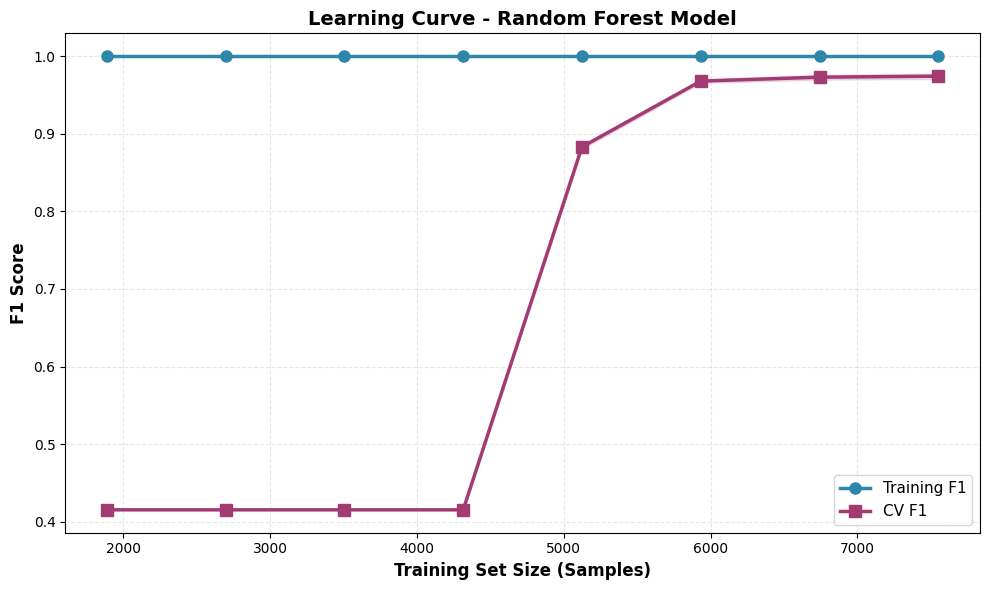


Training score at 100% data: 1.0000
CV score at 100% data: 0.9740
Train-Val Gap: 0.0260


In [18]:
# Use RandomForest for learning curves (no base_score issues)
rf_for_lc = RandomForestClassifier(
    n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1
)

train_sizes = np.linspace(0.25, 1.0, 8)

try:
    train_sizes_abs, train_scores, val_scores = learning_curve(
        rf_for_lc,
        X_train_np,
        y_train_np,
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE),
        scoring="f1_weighted",
        train_sizes=train_sizes,
        n_jobs=-1,
        random_state=RANDOM_STATE,
        error_score="raise",  # This will show us if there are still issues
    )

    train_mean = train_scores.mean(axis=1)
    train_std = train_scores.std(axis=1)
    val_mean = val_scores.mean(axis=1)
    val_std = val_scores.std(axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(
        train_sizes_abs,
        train_mean,
        "o-",
        color="#2E86AB",
        label="Training F1",
        linewidth=2.5,
        markersize=8,
    )
    plt.fill_between(
        train_sizes_abs,
        train_mean - train_std,
        train_mean + train_std,
        alpha=0.15,
        color="#2E86AB",
    )

    plt.plot(
        train_sizes_abs,
        val_mean,
        "s-",
        color="#A23B72",
        label="CV F1",
        linewidth=2.5,
        markersize=8,
    )
    plt.fill_between(
        train_sizes_abs,
        val_mean - val_std,
        val_mean + val_std,
        alpha=0.15,
        color="#A23B72",
    )

    plt.xlabel("Training Set Size (Samples)", fontsize=12, fontweight="bold")
    plt.ylabel("F1 Score", fontsize=12, fontweight="bold")
    plt.title("Learning Curve - Random Forest Model", fontsize=14, fontweight="bold")
    plt.legend(loc="lower right", fontsize=11)
    plt.grid(alpha=0.3, linestyle="--")
    plt.tight_layout()
    plt.savefig(
        FIGURES_DIR / "learning_curve_analysis.png", dpi=300, bbox_inches="tight"
    )
    plt.show()

    # Analysis
    print(f"\nTraining score at 100% data: {train_mean[-1]:.4f}")
    print(f"CV score at 100% data: {val_mean[-1]:.4f}")
    gap = train_mean[-1] - val_mean[-1]
    print(f"Train-Val Gap: {gap:.4f}")

except Exception as e:
    print(f"❌ Error during learning curve computation: {e}")
    print("Skipping learning curve visualization.")

aaaaaaaa

### Learning Curve Findings
- We have sufficient data (learning curve plateaus)
- Generalization is good (2.6% train-val gap)
- But: Tuning made the model worse on held-out validation set

GridSearchCV optimized for CV fold composition, not real-world composition. The tuned hyperparameters overfit to the specific splits used during tuning.

In [47]:
# Save Model
with open(MODELS_DIR / "xgboost.pkl", "wb") as f:
    pickle.dump(xgb_basic, f)

with open(MODELS_DIR / "xgboost_tuned.pkl", "wb") as f:
    pickle.dump(best_xgb_model, f)
print("Models saved.")

# Save tuning results metadata
tuning_metadata = {
    "rf_best_params": xgb_grid_search.best_params_,
    "rf_best_f1_cv": xgb_grid_search.best_score_,
    "rf_val_metrics": xgb_tuned_metrics["val"],
}

with open(PROCESSED_DATA_DIR / "tuning_metadata.json", "w") as f:
    json.dump(tuning_metadata, f, indent=2)
print("Tuning metadata saved.")

Models saved.
Tuning metadata saved.


## Summary
Tuning Methods Used:
  1. **RandomizedSearchCV**: 50 random combinations
  2. **GridSearchCV**: Fine-tuning around best random parameters